In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Step Project

### 1. Problem Definition
##### Predicting survival on the Titanic based on various features like age, sex, passenger class, etc.

### 2. Data Collection

##### The Titanic dataset is readily available on platforms like Kaggle or use seaborn datasets. It typically includes features like Passenger ID, Survived (target variable), Pclass, Name, Sex, Age, SibSp (siblings/spouses aboard), Parch (parents/children aboard), Ticket, Fare, Cabin, and Embarked.

In [2]:
df = pd.read_csv('titanic/train_and_test2.csv')
df.head(4)

,Passengerid,Age,Fare,Sex,sibsp,zero,zero.1,zero.2,zero.3,zero.4,...,zero.12,zero.13,zero.14,Pclass,zero.15,zero.16,Embarked,zero.17,zero.18,2urvived
0,1,22.0,7.2500,0,1,0,0,0,0,0,...,0,0,0,3,0,0,2.0,0,0,0
1,2,38.0,71.2833,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0.0,0,0,1
2,3,26.0,7.9250,1,0,0,0,0,0,0,...,0,0,0,3,0,0,2.0,0,0,1
3,4,35.0,53.1000,1,1,0,0,0,0,0,...,0,0,0,1,0,0,2.0,0,0,1


In [3]:
# Exploring dataset
print('----- Dataset columns -----')
print(df.columns.to_numpy())

# Columns rename for clarity
df.rename(columns={'Passengerid': 'PassengerId', 'sibsp': 'SiblingsSpouses', 'Parch': 'ParentChildren', 'Pclass': 'TicketClass', '2urvived': 'Survived',}, inplace=True)

print('\n----- Dataset info -----')
print(df.info('\n'))
print('\n----- Dataset basic stats -----')
print(df.describe())
print('\n----- Dataset missing values-----')
print(df.isnull().sum())

----- Dataset columns -----
['Passengerid' 'Age' 'Fare' 'Sex' 'sibsp' 'zero' 'zero.1' 'zero.2'
 'zero.3' 'zero.4' 'zero.5' 'zero.6' 'Parch' 'zero.7' 'zero.8' 'zero.9'
 'zero.10' 'zero.11' 'zero.12' 'zero.13' 'zero.14' 'Pclass' 'zero.15'
 'zero.16' 'Embarked' 'zero.17' 'zero.18' '2urvived']

----- Dataset info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      1309 non-null   int64  
 1   Age              1309 non-null   float64
 2   Fare             1309 non-null   float64
 3   Sex              1309 non-null   int64  
 4   SiblingsSpouses  1309 non-null   int64  
 5   zero             1309 non-null   int64  
 6   zero.1           1309 non-null   int64  
 7   zero.2           1309 non-null   int64  
 8   zero.3           1309 non-null   int64  
 9   zero.4           1309 non-null   int64  
 10  zero.5           13

##### Mising values rows before preprocessing 

In [4]:
empty_embarked_idx = df[df['Embarked'].isnull()].index
missing_data_rows = pd.DataFrame(data=df[['PassengerId', 'Embarked']], index=empty_embarked_idx)

missing_data_rows

,PassengerId,Embarked
61,62,NaN
829,830,NaN


### 3.Data Cleaning and Preprocessing

In [5]:
imputer = SimpleImputer(strategy='most_frequent')
df['Embarked'] = imputer.fit_transform(df[['Embarked']])

##### Mising values rows after preprocessing

In [6]:
pd.DataFrame(data=df[['PassengerId', 'Embarked']], index=empty_embarked_idx)

,PassengerId,Embarked
61,62,2.0
829,830,2.0


In [7]:
# Relevant clean data 
relevant_df = df[['PassengerId','Sex', 'Age', 'Fare', 'SiblingsSpouses', 'ParentChildren', 'TicketClass', 'Embarked', 'Survived']]
relevant_df.tail(8)

,PassengerId,Sex,Age,Fare,SiblingsSpouses,ParentChildren,TicketClass,Embarked,Survived
1301,1302,1,28.0,7.7500,0,0,3,1.0,0
1302,1303,1,37.0,90.0000,1,0,1,1.0,0
1303,1304,1,28.0,7.7750,0,0,3,2.0,0
1304,1305,0,28.0,8.0500,0,0,3,2.0,0
1305,1306,1,39.0,108.9000,0,0,1,0.0,0
1306,1307,0,38.5,7.2500,0,0,3,2.0,0
1307,1308,0,28.0,8.0500,0,0,3,2.0,0
1308,1309,0,28.0,22.3583,1,1,3,0.0,0


In [8]:
enc = OneHotEncoder(sparse_output=False)
categorical_columns = ['TicketClass', 'Embarked']
encoded = enc.fit_transform(relevant_df[categorical_columns])
encoded_columns = enc.get_feature_names_out()
encoded_col_df = pd.DataFrame(data=encoded, columns=encoded_columns)
encoded_df = pd.concat([relevant_df.reset_index(drop=True), encoded_col_df.reset_index(drop=True)], axis=1).drop(categorical_columns, axis=1)

encoded_df.tail(5)

,PassengerId,Sex,Age,Fare,SiblingsSpouses,ParentChildren,Survived,TicketClass_1,TicketClass_2,TicketClass_3,Embarked_0.0,Embarked_1.0,Embarked_2.0
1304,1305,0,28.0,8.0500,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0
1305,1306,1,39.0,108.9000,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0
1306,1307,0,38.5,7.2500,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0
1307,1308,0,28.0,8.0500,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0
1308,1309,0,28.0,22.3583,1,1,0,0.0,0.0,1.0,1.0,0.0,0.0


### 4. Exploratory Data Analysis (EDA)

In [9]:
sns.set_style("darkgrid")

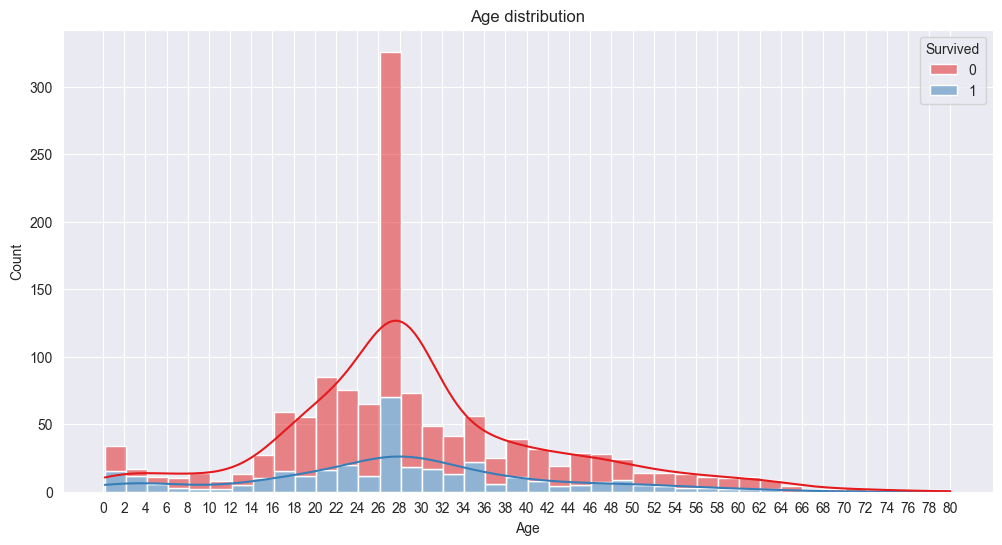

In [10]:
# Age distribution visualization
plt.figure(figsize=(12, 6))
sns.histplot(data=relevant_df, x=relevant_df['Age'], hue=relevant_df['Survived'], multiple='stack', legend=True, binwidth=2, kde=True, palette='Set1')
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(np.arange(0, df['Age'].max() + 2, 2))
plt.show()

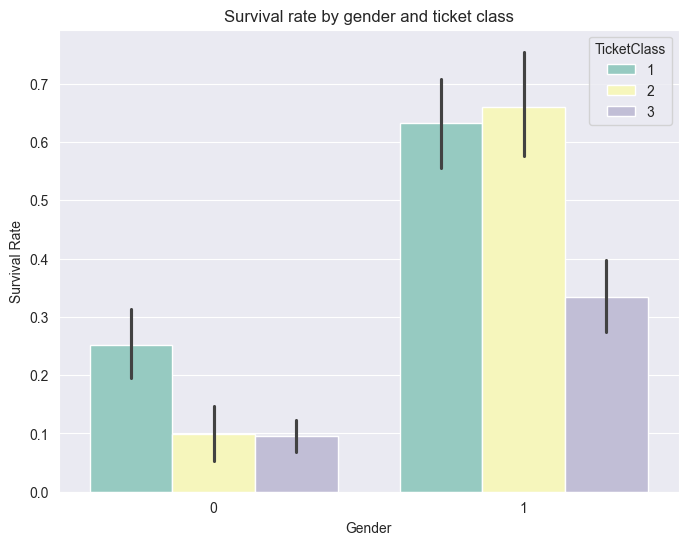

In [11]:
# Visualizing the impact of gender and ticket class
plt.figure(figsize=(8, 6))
sns.barplot(data=relevant_df, x=relevant_df['Sex'], y=relevant_df['Survived'], hue=relevant_df['TicketClass'], legend=True, palette='Set3')
plt.title('Survival rate by gender and ticket class')
plt.xlabel('Gender')
plt.ylabel('Survival Rate')
plt.show()

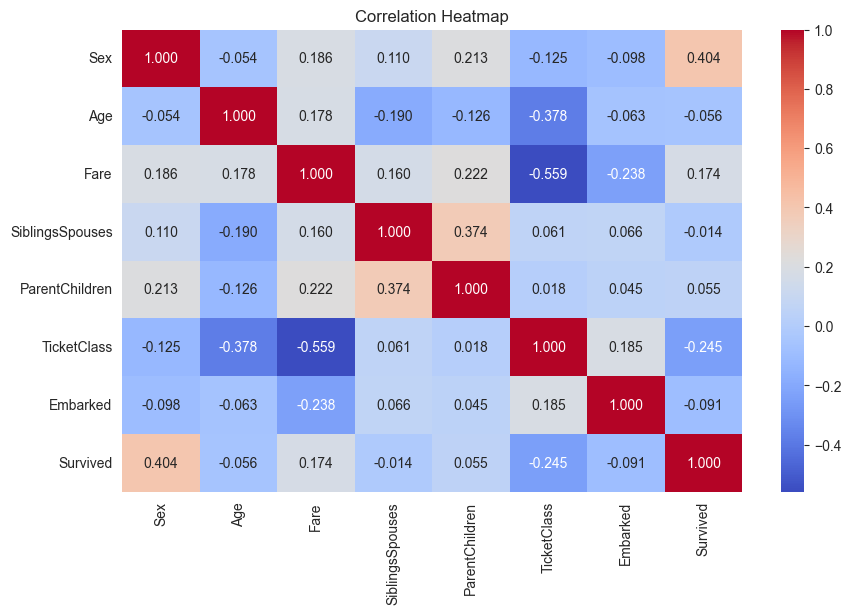

In [12]:
# Correlation Matrix
corr = relevant_df.drop('PassengerId', axis=1).corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Correlation Heatmap')
plt.show()

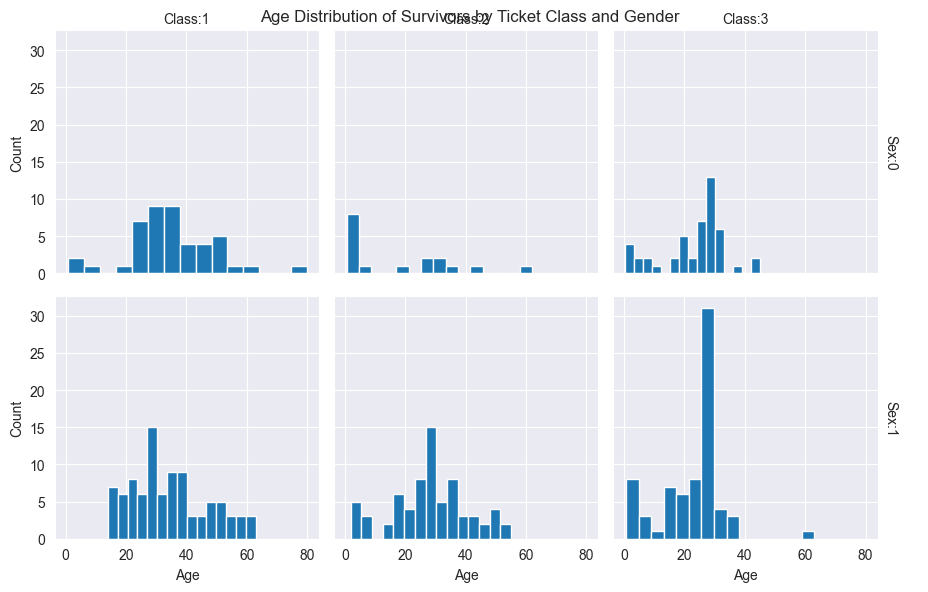

In [13]:
# Visualizing survivors by class, gender and age
survived_df = relevant_df[relevant_df['Survived'] == 1]

fg = sns.FacetGrid(survived_df, col="TicketClass", row="Sex", margin_titles=True)
fg = fg.map(plt.hist, 'Age', bins=15)
fg.set_titles(col_template='Class:{col_name}', row_template='Sex:{row_name}')
fg.fig.suptitle('Age Distribution of Survivors by Ticket Class and Gender')
fg.set_axis_labels('Age', 'Count')
fg.add_legend()
plt.show()

### 5. Feature Engineering

In [14]:
# Adding isAlone indicatior by calculating family size
encoded_df['FamilySize'] = encoded_df['SiblingsSpouses'] + encoded_df['ParentChildren'] + 1
encoded_df['isAlone'] = (encoded_df['FamilySize'] == 1).astype(int)

encoded_df.tail(5)

,PassengerId,Sex,Age,Fare,SiblingsSpouses,ParentChildren,Survived,TicketClass_1,TicketClass_2,TicketClass_3,Embarked_0.0,Embarked_1.0,Embarked_2.0,FamilySize,isAlone
1304,1305,0,28.0,8.0500,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,1,1
1305,1306,1,39.0,108.9000,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0,1,1
1306,1307,0,38.5,7.2500,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,1,1
1307,1308,0,28.0,8.0500,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,1,1
1308,1309,0,28.0,22.3583,1,1,0,0.0,0.0,1.0,1.0,0.0,0.0,3,0


In [48]:
# Preprocessor preparation
prepared_df = encoded_df.drop(['PassengerId', 'ParentChildren', 'SiblingsSpouses', 'FamilySize'], axis=1)

X = prepared_df.drop(columns=['Survived'])
y = prepared_df['Survived']

categorical_columns = ['Sex', 'TicketClass_1', 'TicketClass_2', 'TicketClass_3', 'Embarked_0.0', 'Embarked_1.0', 'Embarked_2.0', 'isAlone']
numerical_columns = ['Age', 'Fare']

preprocessor = ColumnTransformer([
    ('numerical', MinMaxScaler(), numerical_columns),
    ('categorical', 'passthrough', categorical_columns)
])

preprocessor

ColumnTransformer(transformers=[('numerical', MinMaxScaler(), ['Age', 'Fare']),
                                ('categorical', 'passthrough',
                                 ['Sex', 'TicketClass_1', 'TicketClass_2',
                                  'TicketClass_3', 'Embarked_0.0',
                                  'Embarked_1.0', 'Embarked_2.0', 'isAlone'])])

### 6. Model Selection / 7. Model Evaluation

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
MAGIC_RANDOM = 42

selected_models = [
    LogisticRegression(max_iter=1000),
    RandomForestClassifier(random_state=MAGIC_RANDOM),
    GradientBoostingClassifier(random_state=MAGIC_RANDOM),
    MLPClassifier(solver='adam', learning_rate='adaptive', max_iter=2000, random_state=MAGIC_RANDOM)
]

In [147]:
def evaluate_model(model):
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    kf = KFold(n_splits=5, shuffle=True, random_state=123)
    scores = cross_val_score(pipe, X_train, y_train, cv=kf)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f'\n---- {model.__class__.__name__} ----')
    print(f'CV scores: {[f"{i:.3f}" for i in scores]}')
    print(f'AVG CV score: {scores.mean():.3f}')
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', linewidths=0)
    plt.title(f'Confusion Matrix {model.__class__.__name__}')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    print(f'Accuracy: {accuracy:.3f}')
    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'F1 Score: {f1:.3f}')
    plt.show()


---- LogisticRegression ----
CV scores: ['0.783', '0.792', '0.787', '0.776', '0.809']
AVG CV score: 0.789
Accuracy: 0.766
Precision: 0.638
Recall: 0.343
F1 Score: 0.446


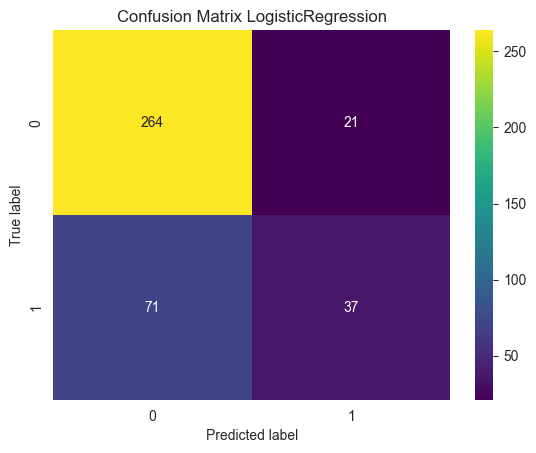


---- RandomForestClassifier ----
CV scores: ['0.761', '0.781', '0.760', '0.754', '0.792']
AVG CV score: 0.770
Accuracy: 0.743
Precision: 0.536
Recall: 0.481
F1 Score: 0.507


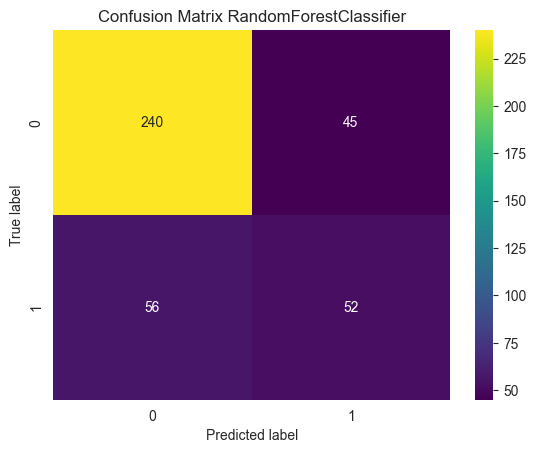


---- MLPClassifier ----
CV scores: ['0.793', '0.814', '0.754', '0.792', '0.809']
AVG CV score: 0.793
Accuracy: 0.768
Precision: 0.631
Recall: 0.380
F1 Score: 0.474


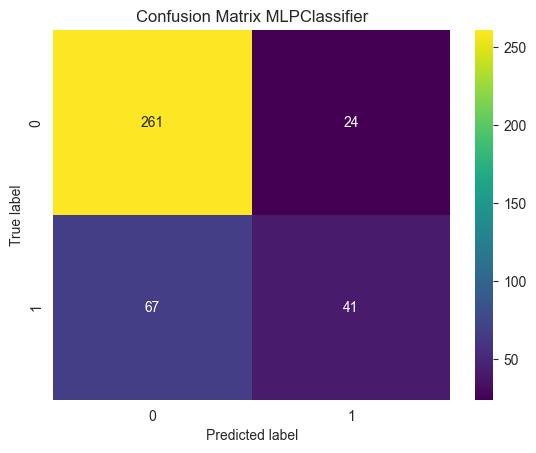

In [139]:
for m in selected_models:
    evaluate_model(m)

### 8. Fine-tuning and Validation


Best parameters for LogisticRegression: {'classifier__C': 10, 'classifier__solver': 'lbfgs'}
Best CV score: 0.785

Best parameters for RandomForestClassifier: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 50}
Best CV score: 0.783

Best parameters for GradientBoostingClassifier: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
Best CV score: 0.794

Best parameters for MLPClassifier: {'classifier__alpha': 0.001, 'classifier__hidden_layer_sizes': (50, 30), 'classifier__max_iter': 1000}
Best CV score: 0.786

---- LogisticRegression ----
Accuracy: 0.768
Precision: 0.639
Recall: 0.361
F1 Score: 0.462


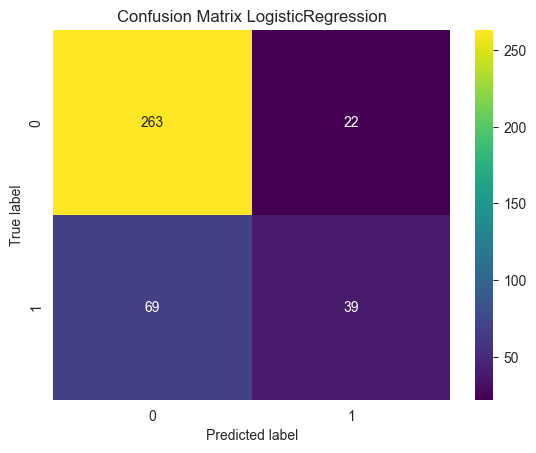


---- RandomForestClassifier ----
Accuracy: 0.774
Precision: 0.617
Recall: 0.463
F1 Score: 0.529


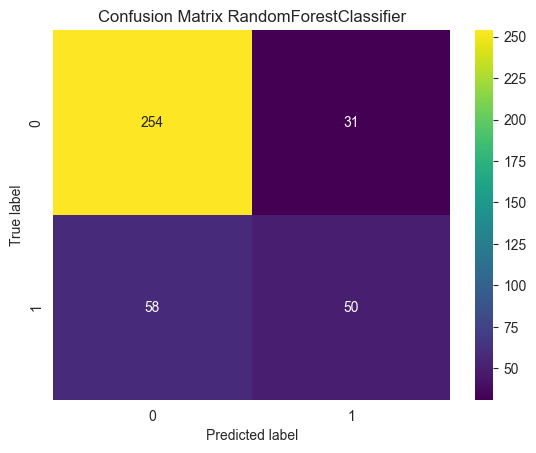


---- GradientBoostingClassifier ----
Accuracy: 0.781
Precision: 0.672
Recall: 0.398
F1 Score: 0.500


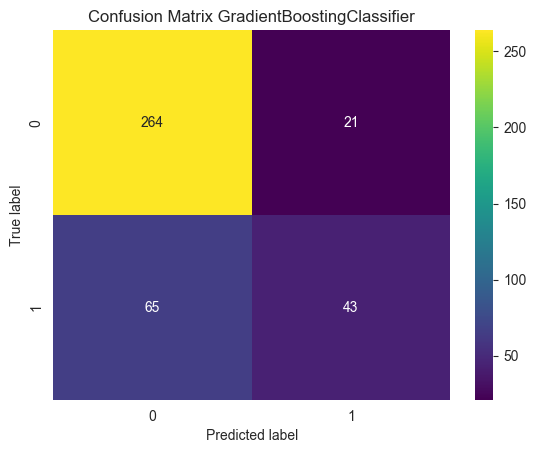


---- MLPClassifier ----
Accuracy: 0.768
Precision: 0.639
Recall: 0.361
F1 Score: 0.462


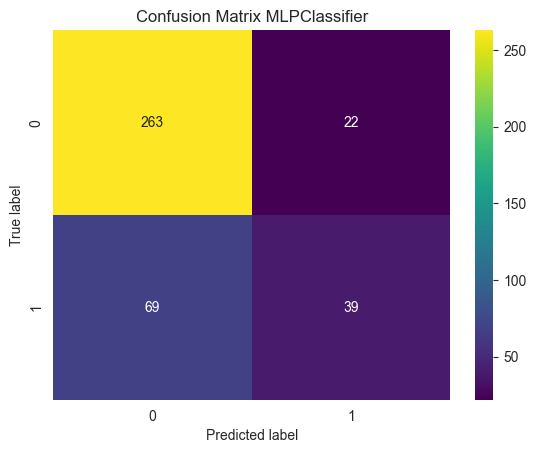

In [154]:
param_grid = {
    'LogisticRegression': {
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['liblinear', 'lbfgs']
    },
    'RandomForestClassifier': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'GradientBoostingClassifier': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7]
    },
    'MLPClassifier': {
        'classifier__hidden_layer_sizes': [(100,), (50, 30)],
        'classifier__alpha': [0.0001, 0.001],
        'classifier__max_iter': [1000, 2000]
    }
}

def evaluate_models_with_grid_search(models, param_grid):
    best_models = {}
    for m in models:
        pipe = Pipeline([('preprocessor', preprocessor),('classifier', m)])
        grid_search = GridSearchCV(pipe, param_grid[m.__class__.__name__], cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_models[m.__class__.__name__] = grid_search.best_estimator_
        print(f'\nBest parameters for {m.__class__.__name__}: {grid_search.best_params_}')
        print(f'Best CV score: {grid_search.best_score_:.3f}')
    return best_models

best_models = evaluate_models_with_grid_search(selected_models, param_grid)

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f'\n---- {name} ----')
    print(f'Accuracy: {accuracy:.3f}')
    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'F1 Score: {f1:.3f}')
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', linewidths=0)
    plt.title(f'Confusion Matrix {name}')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

### 10. Documentation and Presentation

LogisticRegression, RandomForestClassifier, GradientBoostingClassifier and MLPClassifier were used to predict survival on Titanic.

First of all I explored dataset for existing and missing data. Missing data (port) was replaced with most frequent values. Then I applied One-hot-encoding for categorical feautures and tryied to figure out what features have strong impact. Correlation and graphical visualization shows that gender, seats (ticket class) and age are main factors. After model preparations and tests I can summarize:
    Logistic Regression: CV score 0.785 indicates that the model has a decent accuracy.
    Random Forest: CV score 0.783, very close to Logistic Regression.
    Gradient Boosting: CV score 0.794, slightly better than other models.
    MLPClassifier: CV score 0.786, at the level of Logistic Regression.

Gradient Boosting showed the best cross-validation results (CV score 0.794) and the best accuracy on test data (Accuracy 0.781). Random Forest also showed high results and the best Recall value.
Logistic Regression and MLPClassifier have similar results but are slightly behind the other models.